In [7]:
import os
import math
import random
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
import sys
sys.path.append('../')
print(sys.path)

['/Users/t-lqiu/SSD-Tensorflow', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python36.zip', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/lib-dynload', '', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages', '/private/var/folders/tg/lk1f_4dd30ddgdmmgwdzfbqx9yf85s/T/AppTranslocation/553C37F0-F55C-439B-8EC8-05F5DFBF8EA2/d/PyCharm.app/Contents/helpers/pycharm_matplotlib_backend', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/extensions', '/Users/t-lqiu/.ipython', '../', '../']


In [10]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [12]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [70]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
# ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
# ckpt_filename = '../logs/model.ckpt-5707'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'

# 6404和9660基本差不多，start from scratch训练的不是很好，应该使用vgg16位基础创建更好一些
# ckpt_filename = '../checkpoints/model.ckpt-6404'
ckpt_filename = '../checkpoints/model.ckpt-9660'

isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../checkpoints/model.ckpt-9660


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [71]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

['.DS_Store', '000003.jpg', 'bk', 'cat-2083492_640.jpg', 'elephant-1169258_640.jpg', 'elephant-1421167_640.jpg', 'elephant-1822481_640.jpg', 'elephant-1822636_640.jpg', 'elephant-2729415_640.jpg', 'elephant-4102386_640.jpg', 'horses.jpg', 'person.jpg', 'thailand-142982_640.jpg']
../demo
11
[PosixPath('../demo/cat-2083492_640.jpg'), PosixPath('../demo/person.jpg'), PosixPath('../demo/elephant-1169258_640.jpg'), PosixPath('../demo/elephant-4102386_640.jpg'), PosixPath('../demo/elephant-1822636_640.jpg'), PosixPath('../demo/elephant-1822481_640.jpg'), PosixPath('../demo/elephant-2729415_640.jpg'), PosixPath('../demo/horses.jpg'), PosixPath('../demo/elephant-1421167_640.jpg'), PosixPath('../demo/thailand-142982_640.jpg'), PosixPath('../demo/000003.jpg')]


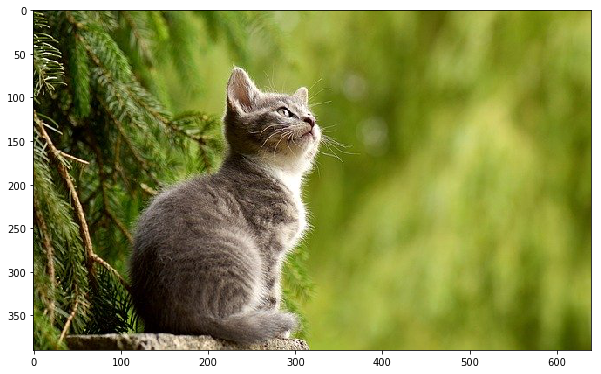

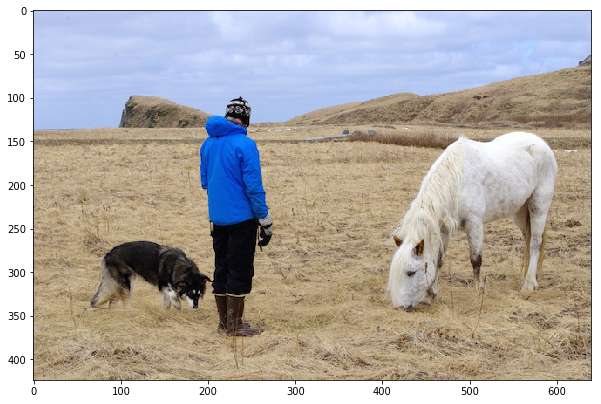

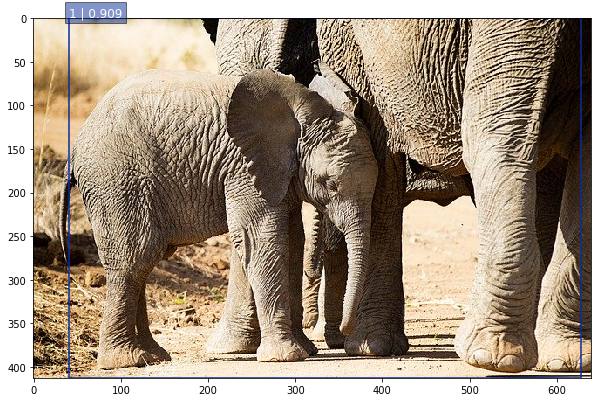

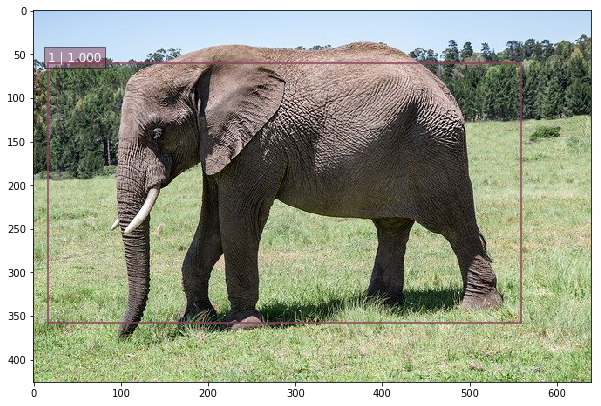

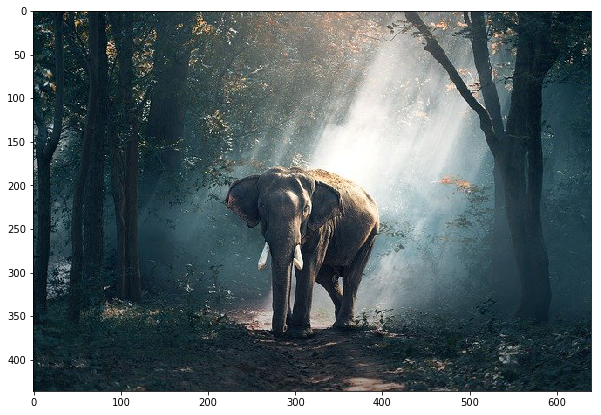

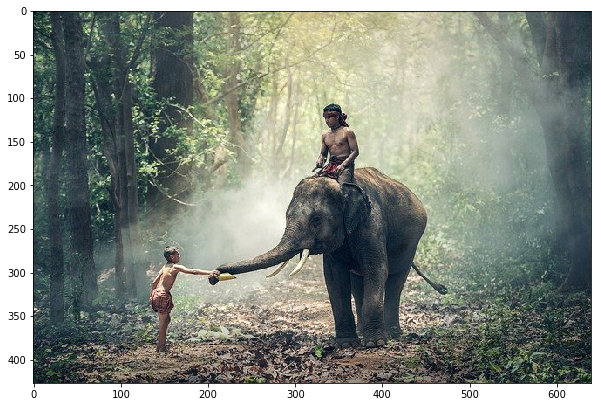

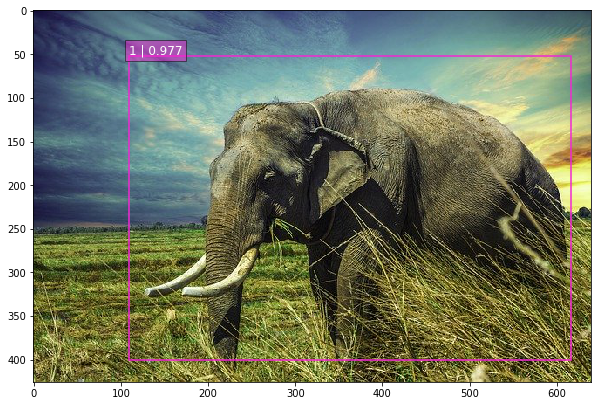

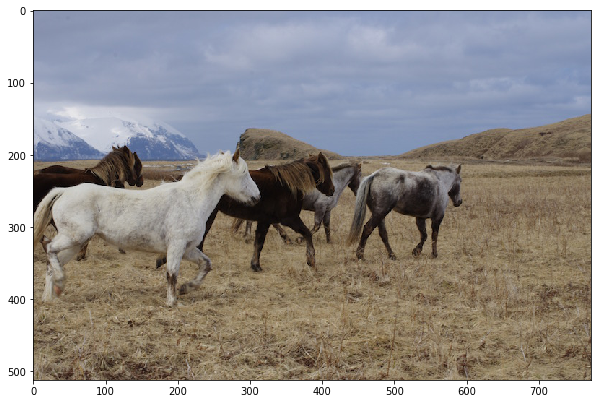

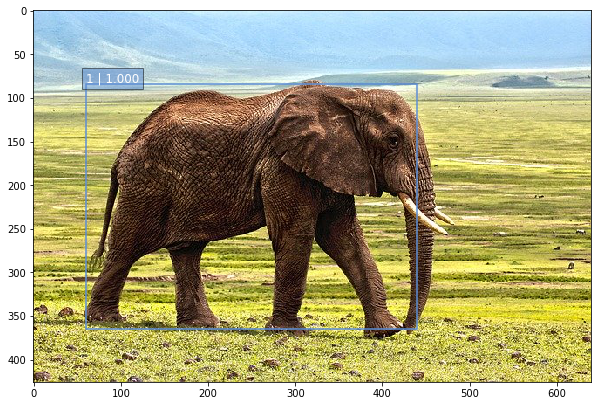

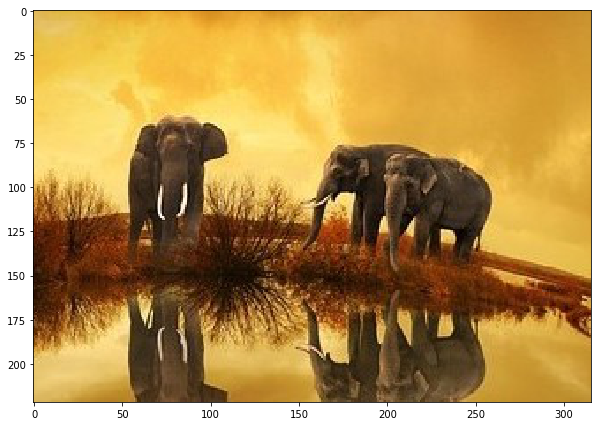

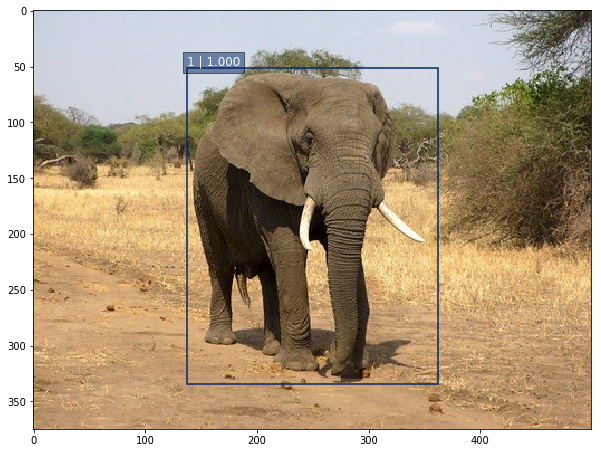

In [75]:
import glob
import pathlib

# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))
print(image_names)

p_temp = pathlib.Path(path)
print(p_temp)

# print(type(p_temp.glob('**/*.jpg')))
# <class 'generator'>

# 本目录下的jpg
pic=list(p_temp.glob('*.jpg'))
# 返回上层然后查看所有子目录下面的jpg
# pic=list(p_temp.glob('**/*.jpg'))
# 本目录以外的其他目录下的jpg
# pic=list(p_temp.glob('*/*.jpg'))

print(len(pic))
print(pic)

for pic_path in pic:
    img = mpimg.imread(pic_path)
    rclasses, rscores, rbboxes =  process_image(img)
    # visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
    visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
